# AIA_image Classification Where_Am_I
## 主要流程：
#### 1.將照片資料讀入並分類
#### 2.分析資料並作轉換
##### 3.建立模型
#### 4.測試模型準確率並畫圖
#### 5.將結果匯出成csv並上傳
## Import Data

In [4]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras import regularizers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 1與2的部分我另外寫在utils.py裡面，並在這裡導入我已寫好的function進來

In [5]:
from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

## 將資料切割做測試並設定img_size

In [6]:
X_train, y_train, X_valid, y_valid = load_data(test_size=0.1, img_size=256)

## 觀察切出來的資料型態

In [7]:
X_train.shape 

(2686, 256, 256, 1)

In [8]:
y_train.shape

(2686, 15)

In [9]:
X_valid.shape

(299, 256, 256, 1)

In [6]:
y_valid.shape

(299, 15)

## 建立模型 這裡使用了5層的卷積＋1 flatten + 2 dense

In [10]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(activation='relu'))

model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation(activation='softmax'))

## 查看模型架構

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0         
__________

## ImageDataGenerator
#### ImageDaraGenerator為當樣本數不夠時可利用此function產生出訓練用的圖片，以下是我用的參數

#### 1.width_shift_range：浮點數，圖片寬度的某個比例，數據提升時圖片水平偏移的幅度
#### 2.height_shift_range：浮點數，圖片高度的某個比例，數據提升時圖片豎直偏移的幅度
#### 3.shear_range：浮點數，剪切強度（逆時針方向的剪切變換角度）
#### 4.zoom_range：浮點數或形如[lower,upper]的列表，隨機縮放的幅度，若為浮點數，則相當於[lower,upper] = [1 - zoom_range, 1+zoom_range]
#### 5.horizo​​ntal_flip：布爾值，進行隨機水平翻轉
#### 6.fill_mode：；‘constant’，‘nearest’，‘reflect’或‘wrap’之一，當進行變換時超出邊界的點將根據本參數給定的方法進行處理
#### 7.cval：浮點數或整數，當fill_mode=constant時，指定要向超出邊界的點填充的值
參考資料：https://keras-cn.readthedocs.io/en/latest/preprocessing/image/

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    #rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)
datagen.fit(X_train)

## 進行訓練
#### 裡面有用到兩個比較不常看到的參數：
#### 1.steps_per_epoch: 一個epoch包含的步數（每一步是一個batch的數據送入），當使用如TensorFlow數據Tensor之類的輸入張量進行訓練時，默認的None代表自動分割，即數據集樣本數/batch樣本數。
#### 2.validation_steps: 僅當steps_per_epoch被指定時有用，在驗證集上的step總數。
#### 參考資料：https://keras-cn.readthedocs.io/en/latest/models/model/

In [10]:
# Fit the model on the batches generated by datagen.flow().
batch_size = 16
aug_ratio = 1
epochs = 200
optimizer = keras.optimizers.Adam(lr=10e-6)
model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
steps_per_epoch = int(aug_ratio * X_train.shape[0] / batch_size)
validation_steps = int(aug_ratio * X_valid.shape[0] / batch_size)
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    steps_per_epoch=steps_per_epoch,
                                    validation_steps=validation_steps)

Epoch 1/200
167/167 [==============================] - 19s 114ms/step - loss: 2.6598 - acc: 0.1569 - val_loss: 2.2492 - val_acc: 0.2642
Epoch 2/200
167/167 [==============================] - 16s 98ms/step - loss: 2.2704 - acc: 0.2603 - val_loss: 1.9971 - val_acc: 0.4181
Epoch 3/200
167/167 [==============================] - 16s 98ms/step - loss: 2.1634 - acc: 0.3037 - val_loss: 1.8936 - val_acc: 0.4281
Epoch 4/200
167/167 [==============================] - 16s 98ms/step - loss: 2.0663 - acc: 0.3396 - val_loss: 1.8042 - val_acc: 0.4783
Epoch 5/200
167/167 [==============================] - 16s 97ms/step - loss: 1.9399 - acc: 0.3983 - val_loss: 1.6460 - val_acc: 0.5284
Epoch 6/200
167/167 [==============================] - 16s 97ms/step - loss: 1.8995 - acc: 0.4134 - val_loss: 1.5931 - val_acc: 0.5318
Epoch 7/200
167/167 [==============================] - 16s 96ms/step - loss: 1.8495 - acc: 0.4372 - val_loss: 1.5208 - val_acc: 0.5652
Epoch 8/200
167/167 [==============================] -

## 將model的權重存起來以便之後再利用

In [11]:
model.save_weights('wher_am_i_200.h5')

## 將分數印出

In [12]:
scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

299/299 [==============================] - 1s 3ms/step
Validation loss: 0.650015394823
Validation accuracy: 0.83277592053


# 將testdata從load_test_data function(utils.py)裡叫出來

In [ ]:
X_test, X_id = load_test_data()

## 將csv輸出

In [14]:
y_test_pred = model.predict_classes(X_test)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('submission.csv', index=False)

## 印出loss與accuarancy function的學習曲線

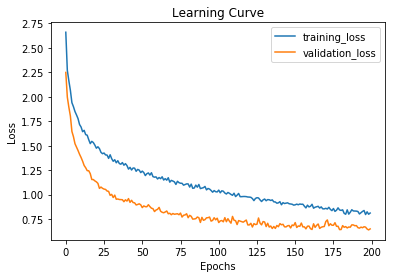

In [15]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

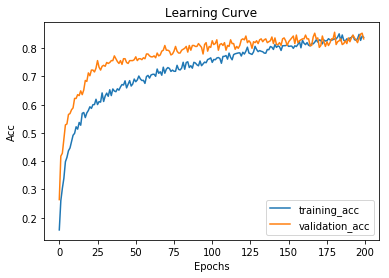

In [16]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

## Kaggle排名

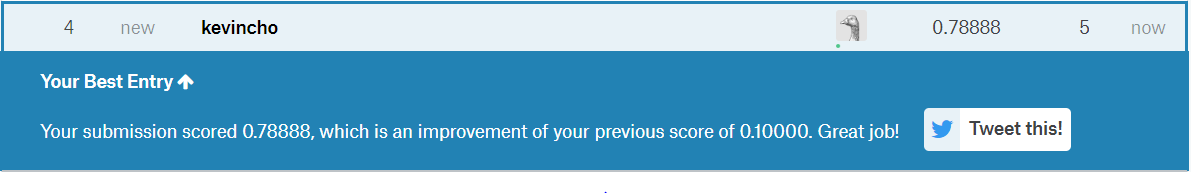

In [13]:
from IPython.display import Image
Image(filename='kaggle.PNG')